<a href="https://colab.research.google.com/github/alexsuakim/Machine-Learning/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMM**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools
import scipy.stats

We're going to implement an algorithm to model data with a mixture of gaussians.

This program is similar to the E-M algorithm of K-means, but this function correctly estimates the covariance matrices of the 2-dimensional gaussian components involved, as well as their means. The "distance" of each of the data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$.


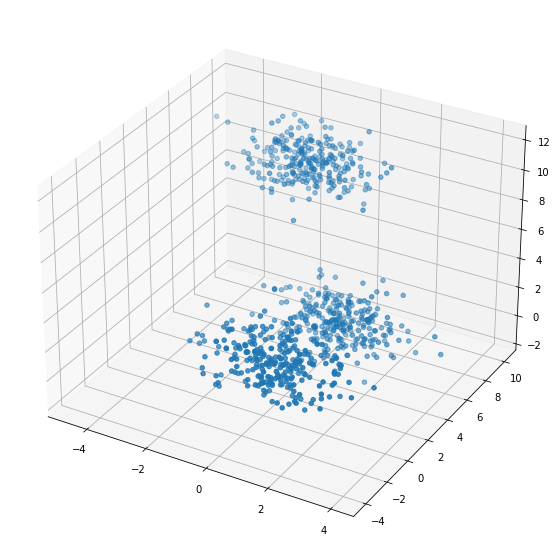

In [ ]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 3 dimensions. They are represented by a three dimensional Gaussian Mixture Model.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilies, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

Initialise the parameters by generating:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

---

In [ ]:
def initialise_parameters(X, K):
    # YOUR CODE HERE
    m, n = X.shape

    #sigma
    arrays = []
    for i in range (K):
        value = np.random.choice(X.ravel(), (n,n))
        mean = np.random.choice(X.ravel(), (n,n))
        diff = value - mean
        diff_squared = diff * diff.T
        matrix = np.diag(np.diag(diff_squared))
        arrays.append(matrix)
    sigma = np.stack(arrays)


    #mu
    mu = np.random.choice(X.ravel(), (K,n))

    #pi
    pi = np.ones(K) / K

    return sigma, mu, pi

K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 19.29037058   0.           0.        ]
  [  0.          29.27477541   0.        ]
  [  0.           0.          48.97704222]]

 [[ 58.52343193   0.           0.        ]
  [  0.         105.34125721   0.        ]
  [  0.           0.         127.5225847 ]]

 [[ 40.85004009   0.           0.        ]
  [  0.          52.94086706   0.        ]
  [  0.           0.          20.73047536]]

 [[  7.40938001   0.           0.        ]
  [  0.           1.65498884   0.        ]
  [  0.           0.           9.37848062]]]

Mu: 
 [[ 1.1716903   2.82083258  1.48748943]
 [ 8.23797226  9.23026505  3.02154786]
 [ 8.69103762 -1.19255048  3.36024999]
 [ 5.10986966  1.9698362   8.86503237]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. Each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column.

---

Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [ ]:
def E_step(pi, mu, sigma, X):
    # YOUR CODE HERE
    m,n = X.shape
    K = len(pi)
    r = np.empty((m, K))
    for i in range (m):
        numerator = np.zeros(K)
        for k in range (K):
            weight = pi[k]
            gaussian = scipy.stats.multivariate_normal.pdf(X[i], mu[k], sigma[k], allow_singular=True)
            numerator[k] = weight * gaussian
        denominator = np.sum(numerator)
        r[i,:] = numerator / denominator

    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[5.74704405e-01 6.19545465e-02 3.63103349e-01 2.37699304e-04]
 [7.08209722e-01 1.80675158e-01 1.11094246e-01 2.08741647e-05]
 [5.41784624e-01 5.73610011e-02 1.80490479e-01 2.20363896e-01]
 ...
 [5.71216776e-01 6.18784349e-02 3.54838758e-01 1.20660317e-02]
 [6.98315169e-01 2.02559914e-01 9.90755133e-02 4.94038731e-05]
 [6.55721376e-01 7.03878847e-02 1.88325881e-01 8.55648585e-02]]


---
Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [ ]:
def M_step(r, X):
    # YOUR CODE HERE

    #shape
    m,n = X.shape
    k = len(r[0])

    #mu
    mu = np.dot(r.T, X) / np.sum(r, axis = 0).reshape(k,1)
    #mu = np.zeros((k,n))
    #for i in range (k):
        #sum = 0
        #for j in range (m):
            #sum += r[j,i] * X[j]
        #mu[i] = sum / np.sum(r[:,i])

    #sigma
    sigma = np.zeros((k,n,n))
    for i in range (k):
        sum = 0
        for j in range (m):
            sum += r[j,i] * np.outer((X[j] - mu[i]), (X[j] - mu[i]).T)
        sigma[i] = sum / np.sum(r[:,i])


    #pi
    pi = np.sum(r,axis=0) / np.sum(r)
    #pi = np.zeros(k)
    #for i in range (k):
        #pi[i] = np.sum(r[:,i]) /  np.sum(r)

    return mu, sigma, pi

mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 2.06281097 -3.00929409 -3.58650392]
  [-3.00929409 15.27908152  9.16123187]
  [-3.58650392  9.16123187 12.58620554]]

 [[ 2.24548996 -3.33244278 -4.01158968]
  [-3.33244278 13.97260505 10.15755053]
  [-4.01158968 10.15755053 13.63934563]]

 [[ 1.73887085 -2.29328744 -2.24434569]
  [-2.29328744 15.36780149  6.0115638 ]
  [-2.24434569  6.0115638   7.75096077]]

 [[ 0.92239693 -0.03043307 -0.48448334]
  [-0.03043307  4.28285588 -0.20124494]
  [-0.48448334 -0.20124494  2.43708338]]]

Mu: 
 [[ 0.11682711  3.78117998  4.85233379]
 [-0.27586241  5.31177114  6.40875241]
 [ 0.66925289  1.8196943   3.72604731]
 [ 1.18307852  2.29524095  2.98104968]]

Pi: 
 [0.64792949 0.10508615 0.20441434 0.04257002]


---
Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [ ]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE

    #size
    kmax = len(pi)

    #maximise
    maxarray = np.zeros((kmax))
    for i in range (kmax):
        maxarray[i] = scipy.stats.multivariate_normal.pdf(x, mu[i], sigma[i], allow_singular=True) * pi[i]
    k = np.argmax(maxarray)
    return k

print(classify(pi, mu, sigma, X[270, :3]))

0


Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which:
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 1.0907788  -0.13426416 -0.00661893]
  [-0.13426416  0.92850082  0.07239302]
  [-0.00661893  0.07239302  0.89267635]]

 [[ 0.88084872  0.05723986 -0.02382201]
  [ 0.05723986  1.00251614 -0.01567987]
  [-0.02382201 -0.01567987  1.04316265]]

 [[ 0.95588032  0.00505882 -0.00603556]
  [ 0.00505882  1.00363664  0.02709631]
  [-0.00603556  0.02709631  0.8815131 ]]]

Mu: 
 [[ 0.91171334 -1.55016013  2.90463154]
 [ 1.03774193  4.21660208  1.86993146]
 [-1.25357656  7.775087    9.36231957]]

Pi: 
 [0.33328693 0.33421312 0.33249995]


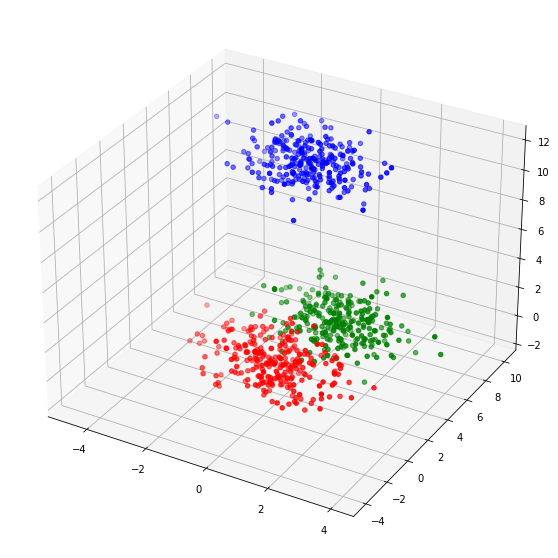

In [ ]:
def EM(X, K, iterations):
    # YOUR CODE HERE

    #initialise
    sigma, mu, pi = initialise_parameters(X,K)

    #iterate E-M
    for i in range(iterations):
        r = E_step(pi,mu,sigma,X)
        mu, sigma, pi = M_step(r,X)

    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 3
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()



---
Image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. In this task, we are going to implement a simple image segmentation algorithm using GMM.

* Inputs:
    - image: the image to be segmented. Type: np.ndarray
    - K: the number of gaussians.
    - iterations: the number of iterations of EM algorithm.
* Return:
    - a matrix, each element of this matrix corresponds to the class of pixels of the input image matrix. Type: np.ndarray. dtype: np.int32.
    - For an image with shape (78,78,3), the shape of returned matrix should be (78,78).


- https://en.wikipedia.org/wiki/Image_segmentation


---

Let's load the image to be segmented first.

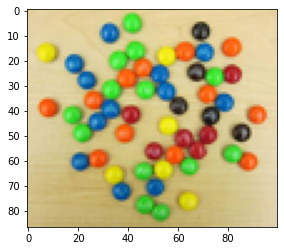

In [ ]:
image = plt.imread('mandm.png')
plt.imshow(image)
plt.show()

It takes 166.6852843761444 seconds to segement the image.


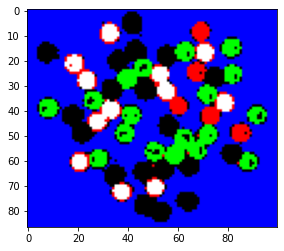

In [ ]:
def image_segmentation(image, K, iterations):
    #reshape
    m,n,o = image.shape
    img = image.reshape(m*n, o)

    #initialise
    sigma, mu, pi = initialise_parameters(img,K)

    #iterate E-M
    for i in range (iterations):
        r = E_step(pi, mu, sigma, img)
        mu, sigma, pi = M_step(r,img)

    #classify
    cluster = np.zeros((m*n), int)
    for i in range (m*n):
        cluster[i] = classify(pi, mu, sigma, img[i,:])
    cluster = cluster.reshape(m,n)

    return cluster

# test code, leave it alone!
import time
start = time.time()
gmm_labels = image_segmentation(image, 5, 10)
end = time.time()
print(f'It takes {end-start} seconds to segement the image.')
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]
segemented_image = np.zeros_like(image, dtype=np.int32)
m, n, _ = segemented_image.shape
for i in range(m):
    for j in range(n):
        segemented_image[i, j] = np.array(colors[gmm_labels[i, j]])
plt.imshow(segemented_image)
plt.show()